In [1]:

import time
import dataframe_image as dfi
import numpy as np
import pandas as pd
import xgboost
import os
import shap
import csv

from fpdf import FPDF
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.inspection import PartialDependenceDisplay as PDP
from sklearn.inspection import partial_dependence as pdep
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
%load_ext autoreload
%autoreload 2
import market_models.src.features.build_features as build_features

xgboost.set_config(verbosity = 0)


In [2]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [29]:
####### PATHS

INPUT = '../data/processed/'
INTERMEDIATE = '../reports/'
OUTPUT = '..data/processed/'

DATA_NAME = 'newprices'

DATA_PATH = f'{INPUT}{DATA_NAME}_processed.csv'
FEATURES_PATH = f'{INPUT}{DATA_NAME}_features.txt'
CATEGORIES_PATH = f'{INPUT}external/'
KPI_DATA_PATH = f'{INTERMEDIATE}{DATA_NAME}_pdf_data/'
PDF_PATH = OUTPUT + DATA_PATH.split('/')[2].replace('.xlsx', '') + '_'


####### CONSTANTS

TEST_SIZE = 0.1
RANDOM_STATE = 42
BONUS_MALUS_CLASSES = ['B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2', 'B1', 'A0', 'M1', 'M2', 'M3', 'M4']
KPI_TABLE_COLUMNS = ['MAE', 'sd MAE', 'RMSE', 'sd RMSE', 'MAPE', 'sd MAPE', 'Avg target']

TARGET_VARIABLE = 'aegon_price'
PRED_TARGET_VARIABLE = f'predicted_{TARGET_VARIABLE}'
CATEGORIES_PATH = f'{CATEGORIES_PATH}{TARGET_VARIABLE}'

PARAMS_GRID = {
    'objective': ['reg:squarederror'],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'enable_categorical': [False, True],
    'eval_metric': ['mae'],
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    'eta': [0.05, 0.1, 0.15]
}


prepareDir(KPI_DATA_PATH)

In [69]:
data = pd.read_csv(DATA_PATH)
with open(FEATURES_PATH) as file:
    features = file.readlines()
    features = [feature.replace('\n', '') for feature in features]
    feature_dtypes = {feature.split(',')[0] : feature.split(',')[1] for feature in features}
    features = [feature.split(',')[0] for feature in features]

for feature in features:
    print(feature, feature_dtypes[feature].replace('object', 'category'))
    data[feature] = data[feature].astype(feature_dtypes[feature])
    if data[feature].dtype == 'category' and feature == 'BonusMalus':
        ordinal_encoder = OrdinalEncoder(categories = [BONUS_MALUS_CLASSES])
        data[feature] = ordinal_encoder.fit_transform(data[[feature]])
    elif data[feature].dtype == 'category':
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])

BonusMalus category
CarAge int64
CarWeightMin int64
NumberOfSeats int64
DriverExperience int64
CarWeightMax int64
kw int64
engine_size int64
driver_age int64
PostalCode int64
CarMake category
Mileage int64


In [70]:
# Make last column name a variable to generelize
data = data[features + [TARGET_VARIABLE]]
data = data.dropna()

In [71]:
data, features = build_features.add_bracket_features(data, features, '../data/external/aegon.json')

In [72]:
features

['BonusMalus',
 'CarAge',
 'CarWeightMin',
 'NumberOfSeats',
 'DriverExperience',
 'CarWeightMax',
 'kw_cut',
 'engine_size_cut',
 'driver_age_cut',
 'PostalCode',
 'CarMake',
 'Mileage']

In [73]:
data.dtypes

BonusMalus           float64
CarAge                 int64
CarWeightMin           int64
NumberOfSeats          int64
DriverExperience       int64
CarWeightMax           int64
kw                     int64
engine_size            int64
driver_age             int64
PostalCode             int64
CarMake                int64
Mileage                int64
aegon_price            int64
kw_cut              category
engine_size_cut     category
driver_age_cut      category
dtype: object

In [74]:
data[features]

,BonusMalus,CarAge,CarWeightMin,NumberOfSeats,DriverExperience,CarWeightMax,kw_cut,engine_size_cut,driver_age_cut,PostalCode,CarMake,Mileage
0,10.0,25,1070,5,38,1470,2.0,4.0,6.0,7400,2,10002
1,10.0,10,1080,5,8,1640,2.0,3.0,1.0,2151,3,10002
2,10.0,10,1310,5,33,1815,4.0,4.0,5.0,9934,3,10002
3,10.0,12,1276,4,30,1630,3.0,2.0,5.0,1213,3,10002
4,10.0,12,1280,5,6,1785,5.0,3.0,1.0,9766,3,10002
...,...,...,...,...,...,...,...,...,...,...,...,...
294291,14.0,7,1054,5,24,1495,2.0,2.0,5.0,9082,42,10002
294292,14.0,3,1765,5,20,2140,5.0,5.0,4.0,4400,52,10002
294293,14.0,8,1581,5,0,2219,7.0,5.0,NaN,2330,111,10002
294294,14.0,15,1079,5,2,1580,1.0,3.0,5.0,2194,111,10002


In [75]:
# Make data overview

describe = pd.concat([data.describe(), pd.DataFrame(np.array([len(data[col].unique()) for col in data.columns]).reshape(1, -1), index = ['unique'], columns = data.columns)])
describeStyle = describe.T.style.format(precision = 2)
dfi.export(describeStyle, KPI_DATA_PATH + 'dataOverview.png', dpi = 200)

In [76]:
# Various model related methods

def modelFit(trData, n_estimators = 1200, max_depth = 8):
    model = xgboost.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, eta=0.1, gamma = 5, subsample=1, colsample_bytree=0.8, min_child_weight = 1 , eval_metric = 'mae', enable_categorical = True)
    model.fit(transposed_train[features], transposed_train[ TARGET_VARIABLE])
    return model

def makeDMatrix(features, target):
    return xgboost.DMatrix(features, target, enable_categorical = True)

def modelTrain(trData, teData):

    dtrain = xgboost.DMatrix(trData[features], trData[TARGET_VARIABLE], enable_categorical = True)
    dtest = xgboost.DMatrix(teData[features], teData[TARGET_VARIABLE], enable_categorical = True)
    param = {'max_depth' : 5, 'eta' : 0.2, 'eval_metric' : 'mae' }
    evallist  = [(dtest,'eval'), (dtrain,'train')]
    num_round = 400
    return xgboost.train( param, dtrain, num_round, evals = evallist, verbose_eval = False)

def mergePredictions(model):
    output = transposed_test.copy()
    try:
        output[ PRED_TARGET_VARIABLE] = model.predict(transposed_test[features])
    except Exception as e:
        dtest = xgboost.DMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE], enable_categorical = True)
        output[ PRED_TARGET_VARIABLE] = model.predict(dtest)
    output['error'] = output[TARGET_VARIABLE] - output[ PRED_TARGET_VARIABLE]
    output['percentageError'] = output['error'] / output[TARGET_VARIABLE] * 100
    return output

def plotHistErrorPercenage(preds):
    plt.hist(preds.percentageError, range = [-100, 100], bins = 40, weights = np.ones(len(preds.percentageError)) / len(preds.percentageError))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(KPI_DATA_PATH + 'ErrorDistribution.jpg')
    plt.show()

def plotFeatureDistribution(data, feature):
    plt.figure(figsize = (10, 10))
    if feature in feature_dtypes.keys() and feature_dtypes[feature] == 'bool':
        data[feature].value_counts().plot(kind = 'bar', title = feature)
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches = 'tight')
    else:
        plt.hist(data[feature], bins = 40, weights = np.ones(len(data[feature])) / len(data[feature]), alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches = 'tight')
    plt.close()



In [77]:
makeDMatrix(data[features], data[TARGET_VARIABLE])

In [78]:
def kFoldCrossValidation(k = 5):
    kf = KFold(n_splits=k)
    maes = []
    mses = []
    mapes = []
    fold_num = 0
    for transposed_train, transposed_test in kf.split(data):
        fold_num += 1
        transposed_train, transposed_test = data.iloc[transposed_train], data.iloc[transposed_test]
        trainModel = modelTrain(transposed_train, transposed_test)
        dmat = makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE])
        mae = mean_absolute_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mse = mean_squared_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mape = mean_absolute_percentage_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        print(f"Summary for fold {fold_num}")
        print("Mean absolute error is {}, which is {}% of mean {}.".format(round(mae, 3), round(mae / data[TARGET_VARIABLE].mean() * 100, 3), TARGET_VARIABLE))
        print("Mean square error is {}.".format(round(mse, 3)))
        print("Mean absolute percentage error is {}%.".format(round(mape * 100, 3)))
        print("-------------------------------------------------------------")
        maes.append(mae)
        mses.append(mse)
        mapes.append(mape)
    return maes, mses, mapes

In [79]:
k = 3
maes, mses, mapes = kFoldCrossValidation(k = k)
mMae, sMae = np.mean(maes), np.std(maes)
mRMse, sRMse = np.mean(np.sqrt(mses)), np.std(np.sqrt(mses))
mMape, sMape = np.mean(mapes), np.std(mapes)
meanPrice = data[TARGET_VARIABLE].mean()

rmMae, rsMae = round(mMae, 2), round(sMae / mMae * 100, 3)
rmRMse, rsRMse = round(mRMse, 2), round(sRMse / mRMse * 100, 2)
rmMape, rsMape = round(mMape * 100, 2), round(sMape / mMape, 3)

print(f"Mean MAE over {k} fold Cross-validation is {rmMae} ± {rsMae}%, which is {round(mMae / meanPrice * 100, 3)} ± {round(sMae / meanPrice * 100, 3)}% percent of mean {TARGET_VARIABLE}.")
print(f"Mean RMSE over {k} fold Cross-validation is {rmRMse} ± {rsRMse}%.")
print(f"Mean MAPE over {k} fold Cross-validation is {rmMape} ± {rsMape}%.")


Summary for fold 1
Mean absolute error is 11888.962, which is 27.483% of mean aegon_price.
Mean square error is 398733325.195.
Mean absolute percentage error is 24.331%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 10375.144, which is 23.984% of mean aegon_price.
Mean square error is 162755454.528.
Mean absolute percentage error is 30.511%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 9093.86, which is 21.022% of mean aegon_price.
Mean square error is 249446870.788.
Mean absolute percentage error is 18.305%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 10452.66 ± 10.929%, which is 24.163 ± 2.641% percent of mean aegon_price.
Mean RMSE over 3 fold Cross-validation is 16173.25 ± 18.28%.
Mean MAPE over 3 fold Cross-validation is 24.38 ± 0.204%.


In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# 'TARGET_VARIABLE' is the target variable name

# Extract features and target variable
X = data[features].values
y = data[TARGET_VARIABLE].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model using TensorFlow and Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Assuming a regression task, so no activation for the output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f"Mean Squared Error on Test Set: {loss}")


2023-11-24 14:04:53.279073: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 14:04:53.496132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 14:04:53.496219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 14:04:53.528919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 14:04:53.595740: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 14:04:53.596911: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/50
7358/7358 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 2/50
3737/7358 [==============>...............] - ETA: 3s - loss: nan

KeyboardInterrupt: 

In [62]:
np.mean(np.abs(model.predict(X_test_scaled).ravel() - y_test))

1840/1840 [==============================] - 1s 498us/step


5480.615350165514

In [57]:
np.mean(np.abs(model.predict(X_test_scaled).ravel() - y_test))

1840/1840 [==============================] - 1s 433us/step


6278.3847612780855

In [53]:
loss / len(y_test)

2345.342031940197

In [16]:
kpi_data = [[rmMae, rsMae, rmRMse, rsRMse, rmMape, rsMape, round(data[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data = kpi_data, columns = KPI_TABLE_COLUMNS).astype('str')

In [17]:
for col in data.columns:
    plotFeatureDistribution(data, col)

In [80]:
transposed_train, transposed_test = train_test_split(data, test_size = 0.2, random_state = 42)
model = modelTrain(transposed_train, transposed_test)

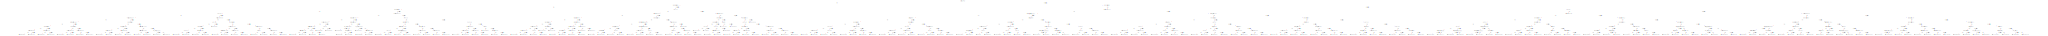

In [60]:
xgboost.to_graphviz(model, num_trees=2, e)

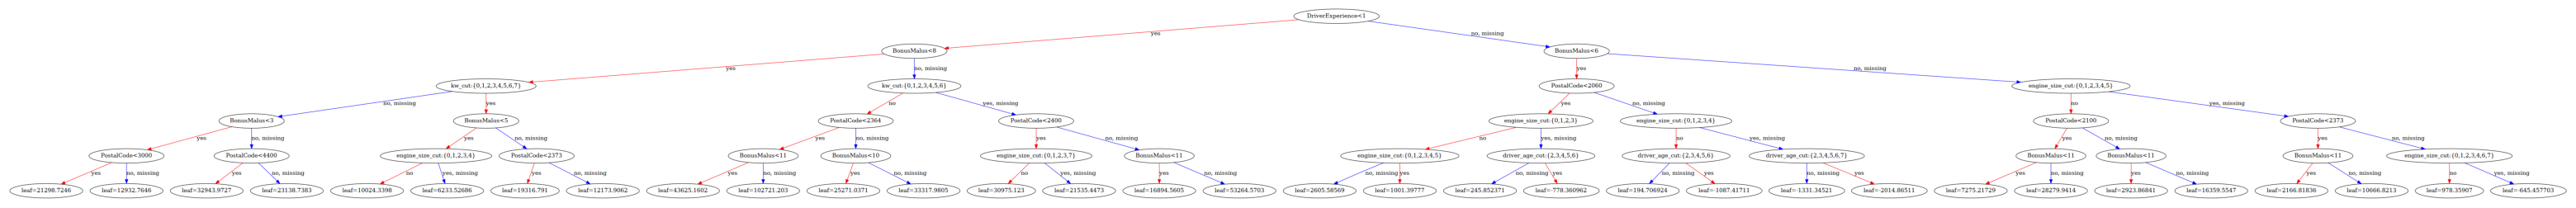

In [81]:
xgboost.plot_tree(model, num_trees=2, rankdir='TB', ax = plt.figure(figsize = (40, 40)).add_subplot(111))
plt.savefig('xgboost_tree.png')

# Show the plot (optional)
#plt.show()

In [82]:
scModel = xgboost.XGBRegressor(n_estimators = 1200, max_depth = 6)
scModel.fit(transposed_train[features].select_dtypes(include='number'), transposed_train[TARGET_VARIABLE])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
explainer = shap.Explainer(scModel)
shap_values = explainer.shap_values(transposed_test[features].values[ : 1000])

shap.summary_plot(shap_values, transposed_test[features].iloc[ : 1000], feature_names = features)

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

In [24]:
data.iloc[id]

BonusMalus              2.000000
CarAge                 14.000000
CarWeightMin         1535.000000
NumberOfSeats           5.000000
DriverExperience       32.000000
CarWeightMax         2055.000000
kw                    110.000000
engine_size          1910.000000
driver_age             50.000000
PostalCode           6100.000000
CarMake                 3.000000
Mileage             10002.000000
aegon_price            10.979241
Name: 21, dtype: float64

In [84]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=transposed_test.iloc[id],
                                     feature_names=features),
                    max_display=8)  # Adjust max_display as needed

plt.show()

NameError: name 'shap_values' is not defined

<Figure size 2000x2000 with 0 Axes>

In [101]:
data['PostalCode']

0         1933
1          233
2         3054
3          149
4         2998
          ... 
294291    2733
294292    1195
294293     290
294294     255
294295     110
Name: PostalCode, Length: 294296, dtype: int64

In [95]:
def pdpSingle(feature):
    return PDP.from_estimator(scModel, transposed_train[features].select_dtypes(include = 'number'), [feature], kind='both', ice_lines_kw = {"color" : "black"}, centered = True, pd_line_kw = {"color" : "red", "lw" : 3, "linestyle" : "--"})

for col in transposed_train[features].select_dtypes(include = 'number').columns:
    pdpSingle(col).figure_.savefig(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg')
    plt.close()

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


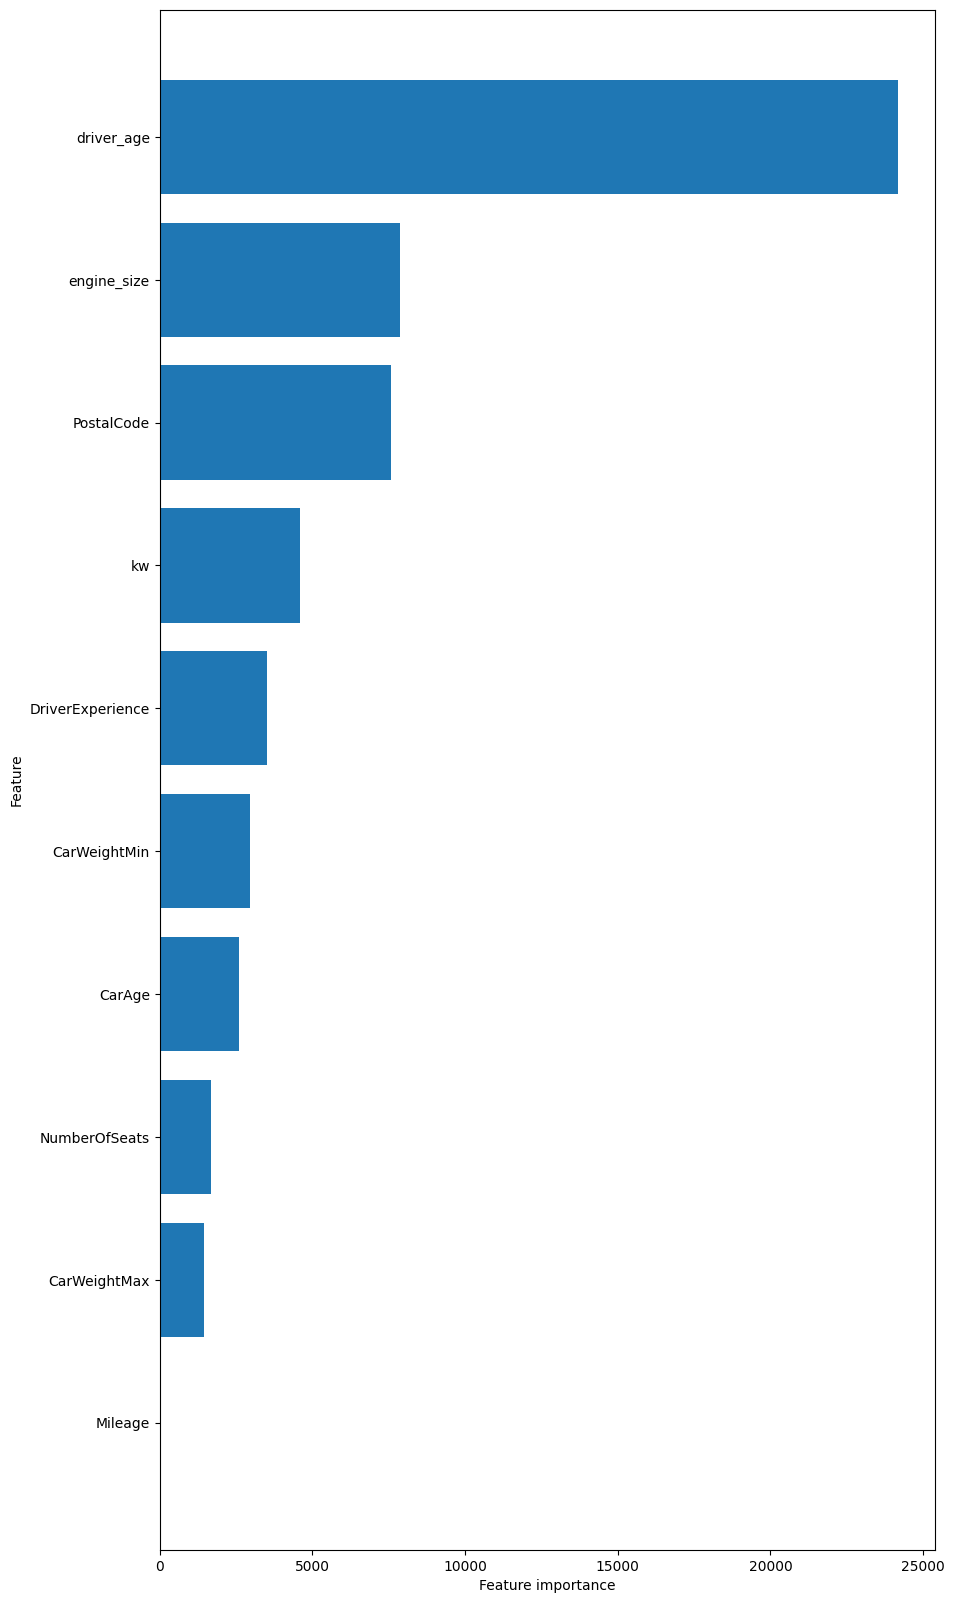

In [96]:
partialDepenadanceFeatureImportance = []
for col in transposed_train[features].select_dtypes(include = 'number').columns:
    partialDepenadanceFeatureImportance.append(np.std(pdep(scModel, transposed_train[features].select_dtypes(include = 'number'), [col])['average']))

cols = transposed_train[features].select_dtypes(include = 'number').columns
ind = [x for _, x in sorted(zip(partialDepenadanceFeatureImportance, cols))]
plt.figure(figsize = (10, 20))
plt.barh(y = ind, width = sorted(partialDepenadanceFeatureImportance))
plt.ylabel('Feature')
plt.xlabel('Feature importance')
plt.savefig(KPI_DATA_PATH + 'PDPimportancePlot.jpg', bbox_inches = 'tight')

In [50]:
def getQauntSplit(step = 50):
    return [i / 1000 for i in range(0, 1001, step)]

quant = getQauntSplit(int(np.ceil(100000 / len(transposed_train))))
qr = transposed_test[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha = 0.8, s = 40)
x = np.linspace(qr.min(),  qr.max())
plt.plot(x, x, c = 'r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches = 'tight')
plt.close()

In [52]:
def quantPlot(out, feature, numQuant = 20):
    type = True # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())
        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1
        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]


    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize = (14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'b', alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'b', alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))




    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches = 'tight')
    plt.close()
    ret =  pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[ PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret

out = mergePredictions(model)
agg_errors = {}
for col in transposed_test.columns:
    agg_errors[col] = quantPlot(out, col)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


In [53]:
# Function to compare two models based on quantile mean aggregated by a feature

def quantPlots(outs, feature, numQuant = 20):
    type = True
    fQuant = None
    featureCol = outs[0][feature]
    if len(featureCol.unique()) < numQuant:
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = featureCol
        type = False
    else :
        fQuant = featureCol.quantile(getQauntSplit(1000 // numQuant)).values
        print(fQuant)
        def getQId(x):
            id = 0
            while id < len(fQuant) - 1 and x > fQuant[id]:
                id += 1
                if x <= fQuant[id]:
                    break
            return max(0, id - 1)
        quantCat = featureCol.apply(lambda x : getQId(x))
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = quantCat

    agg_ages = [outs[i].groupby('QuantCat') for i in range(0, len(outs))]
    fig, ax = plt.subplots(figsize = (14, 14))
    ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_ages[0][TARGET_VARIABLE].mean(), marker = 'o', color = 'b', alpha=0.6)
    for agg_age in agg_ages:
        ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean(), marker = 'o', color = 'r', alpha=0.6)
    if type:
        ax.set_xticks(range(0, numQuant + 1))
    else:
        ax.set_xticks(sorted(list(outs[0]['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real'] + ['Predicted' + str(i) for i in range(1, len(outs) + 1)])
    plt.savefig(KPI_DATA_PATH + 'quantPlots' + col + '.jpg', bbox_inches = 'tight')
    plt.show()
    ret =  pd.DataFrame(np.array([agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean() for agg_age in agg_ages])).T
    ret.columns = ['Model' + str(i) + ' error' for i in range(1, len(outs) + 1)]
    print(ret.index)
    if type:
        cats = list(pd.Series(fQuant).unique())
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]
        for i in range(len(cats)):
            print(feature, cats[i], agg_age[TARGET_VARIABLE].mean().iloc[i])
        ret.index = cats

    return ret

In [54]:
# Inherits FPDF class

class PDF(FPDF):
    def __init__(self):
        super().__init__()
    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8,'Model', 0, 1, 'C')
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')
# Create the KPI report PDF

def makePDF():
    ch = 8
    QUANT_W = 120
    QUANT_H = 120


    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', '', 12)

    for j in range(len(kpi.columns)):
            pdf.cell(w = 25, h = ch, txt = kpi.columns[j], border = 1, ln = j == (len(kpi.columns) - 1), align = 'C')
    for j in range(len(kpi.columns)):
            pdf.cell(w = 25, h = ch, txt = kpi[kpi.columns[j]].iloc[0] + ('%' if j % 2 else ''), border = 1, ln = 0, align = 'C')

    pdf.set_font('Arial', '', 12)
    pdf.cell(w = 40, h = 3 * ch, txt = ' ', border = 0, ln = 1, align = 'C')
    pdf.cell(w = 40, h = ch, txt = 'Parameter', border = 1, ln = 0, align = 'C')
    pdf.cell(w = 40, h = ch, txt = 'Value', border = 1, ln = 0, align = 'C')
    pdf.cell(w = 75, h = ch, txt = 'GridSpace', border = 1, ln = 1, align = 'C')
#    for col, val in params.items():
#        pdf.cell(w = 40, h = ch, txt = col, border = 1, ln = 0, align = 'C')
#        pdf.cell(w = 40, h = ch, txt = str(val), border = 1, ln = 0, align = 'C')
#        pdf.cell(w = 75, h = ch, txt = str(paramsGrid[col]), border = 1,  ln = 1, align = 'C')


    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'dataOverview.png', w = 200, h = 120, type = 'PNG')

    pdf.add_page()

    idx = 1
    for col in features:
        pdf.image(KPI_DATA_PATH + col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * 90, w = 150, h = 90, type = 'JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'PDPimportancePlot.jpg', w = 160, h = 200, type = 'JPG')
    pdf.image(KPI_DATA_PATH + 'QQplot.jpg', w = 150, h = 150, x = 100, type = 'JPG')
    #pdf.image('quantPlotminPrice.jpg', w = 150, h = 150, x = 100, type = 'JPG')


    pdf.add_page()
    idx = 1
    for col in transposed_train[features].select_dtypes(include = 'number').columns:
        pdf.image(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg', x = 10, y = 5 + (idx - 1) * 90, w = 150, h = 90, type = 'JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    idx = 1
    for col in [transposed_test.columns[-1]] + list(transposed_test.columns[ : -1]):
        try :
             pdf.image(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 20), w = QUANT_W, h = QUANT_H, type = 'JPG')
        except Exception as e:
            continue
        # pdf.image(col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 120), w = QUANT_W  / 2, h = QUANT_H / 2, type = 'JPG')
        pdf.set_xy(x = QUANT_W + 20, y = 10 + (idx - 1) * (QUANT_H + 20))
        pdf.set_font('Arial', '', 8)
        pdf.cell( w = 29, h = ch, txt = col + ' agg', border = 1, ln = 0, align = 'C')
        pdf.cell(w = 29, h = ch, txt = 'Mean error', border = 1, ln = 1, align = 'C')
        #print(agg_errors[col].iloc[0])
        mx = agg_errors[col].iloc[  :, 0].max()
        mn = agg_errors[col].iloc[ : , 0].min()

        for i in range(0, len(agg_errors[col])):
            pdf.set_x(QUANT_W + 20)
            cat = agg_errors[col].iloc[i].name
            val = agg_errors[col].iloc[i].values[0]
            print(cat, val)
            if val == mn:
                pdf.set_fill_color(r = 255, g = 0, b = 0)
            elif val == mx:
                pdf.set_fill_color(r = 0, g = 0, b = 255)
            else:
                pdf.set_fill_color(r = 255, g = 255, b = 255)

            pdf.cell(w = 29, h = ch / 2, txt = str(cat), border = 1, fill = 1, ln = 0, align = 'C')
            pdf.cell(w = 29, h = ch / 2, txt = str(round(val, 0)), fill = 1, border = 1, ln = 1, align = 'C')

        idx += 1
        if idx == 3:
            idx = 1
            pdf.add_page()

    return pdf


In [64]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

53640.0-59760.0 -252.7603218129152
59760.0-62400.0 -393.88671875
62400.0-65160.0 -560.7262561274474
65160.0-67560.0 -632.859375
67560.0-70680.0 -1904.392510775855
70680.0-74760.0 -1476.621329697984
74760.0-79164.0 -1954.239653716213
79164.0-84840.0 -2203.65625
84840.0-91320.0 -1450.4332005033502
91320.0-97440.0 -1731.1023385761655
97440.0-104520.0 -1758.4931187913899
104520.0-110400.0 -1172.088506711414
110400.0-118800.0 -1474.6838613013679
118800.0-127200.0 -1488.7037975993444
127200.0-134760.0 -108.24737835570704
134760.0-145800.0 300.8753188775445
145800.0-155400.0 1012.5033557046845
155400.0-175200.0 3098.259374999994
175200.0-206892.0 745.9913903061242
206892.0-894000.0 11453.246875000012
2023_02_14 -899.2578125
2023_02_21 -37.7014484978572
2023_02_24 879.2180059523671
2023_03_01 -720.4016544117767
2023_06_01 2022.7376644736796
False -207.17491610738216
True 2022.7376644736796
ALFA ROMEO 6582.778952205874
AUDI 6161.3627717391355
BMW -961.5180288461561
CHEVROLET -3797.078125
CITROE

''

In [70]:
dmat = xgboost.DMatrix(data[features], data[TARGET_VARIABLE], enable_categorical = True)
param = {'max_depth' : 10, 'eta' : 0.2, 'eval_metric' : 'mae' }
finalModel = xgboost.train(param, dmat, 400)
finalModel.save_model(PDF_PATH + TARGET_VARIABLE +  "_model.json")